In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [23]:
import numpy as np
import pandas as pd
import datetime as dt
import datetime

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text, inspect

In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
print(list(Base.classes)) 

[<class 'sqlalchemy.ext.automap.station'>, <class 'sqlalchemy.ext.automap.measurement'>]


In [7]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create a session
session = Session(engine)

In [9]:
# Inspector

# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
tables = inspector.get_table_names()

# print metadata for each table
for table in tables:
    print(table)
    print("-----------")
    
    # get columns
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

measurement
-----------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
-----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).first()
print(most_recent_date)

('2017-08-23',)


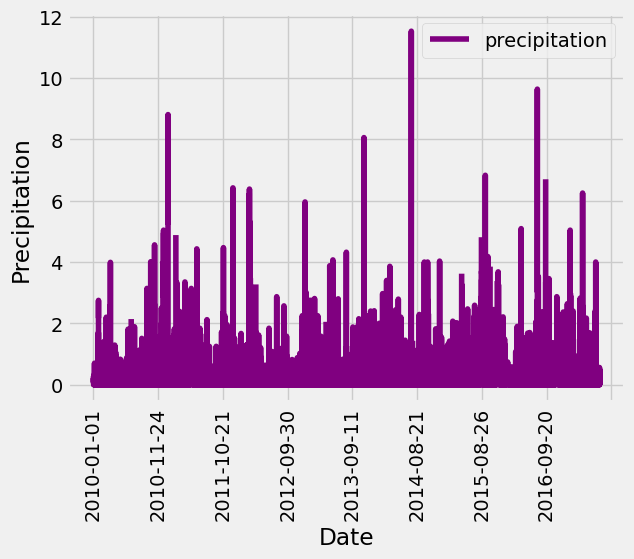

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
prev_year = dt.datetime.strptime(most_recent_date[0], "%Y-%m-%d") - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_data, columns = ["date", "precipitation"])

# Sort the dataframe by date
precip_df = precip_df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(x="date", y="precipitation", rot=90, color = "purple")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.id)).all()

[(9,)]

In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).all()

new_df = pd.DataFrame(most_active_stations, columns=["Station", "Observations"])
new_df.head()

,Station,Observations
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612


In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_stats = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

active_df = pd.DataFrame(active_stats, columns=["min_temp", "avg_temp", "max_temp"])
active_df.head()

,min_temp,avg_temp,max_temp
0,54.0,71.663781,85.0


In [26]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
init_date = datetime.date(2016, 8, 23)

temps = session.query(Measurement.date, Measurement.station, Measurement.tobs).filter(Measurement.date >= init_date).filter(Measurement.station == 'USC00519281').order_by(Measurement.date.asc()).all()

temps_df = pd.DataFrame(temps, columns=["Date", "Station", "TOBS"])

temps_df["Date"] = pd.to_datetime(temps_df['Date'])
temps_df = temps_df.sort_values(by="Date", ascending=True).reset_index(drop=True)

temps_df.head()

,Date,Station,TOBS
0,2016-08-23,USC00519281,77.0
1,2016-08-24,USC00519281,77.0
2,2016-08-25,USC00519281,80.0
3,2016-08-26,USC00519281,80.0
4,2016-08-27,USC00519281,75.0


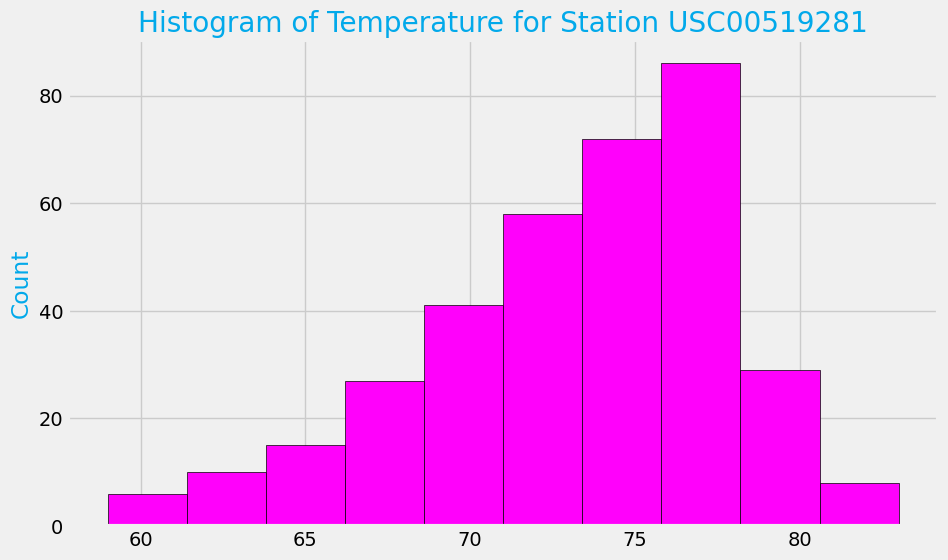

In [34]:
# Plotting histogram

plt.figure(figsize=(10,6))
plt.hist(temps_df.TOBS, color="#FF01FB", edgecolor="black")  # Correct edgecolor for bar outlines - code from chatGPT
plt.ylabel("Count", color="#02A9EA")
plt.title("Histogram of Temperature for Station USC00519281", color="#02A9EA")
plt.show()

# Close Session

In [35]:
# Close Session
session.close()
